In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# generate transitions

#  these are fixed
transitions_0 = np.eye(4)
transitions_1 = np.zeros([4,4])
transitions_1[:,-1] = 0.2
transitions_1[-1,-1] = 0

#  these are the ones we want to learn
indices = np.array([[0,1],
                  [0,2],
                  [1,0],
                  [1,2],
                  [2,0],
                  [2,1],
                  [3,0],
                  [3,1]])


transitions_1[indices[:,0],indices[:,1]] = 0.4
transitions_1[3,2] = 0.2
transitions_1

transitions = {0: transitions_0,
               1: transitions_1}

transitions[0], transitions[1]

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0. , 0.4, 0.4, 0.2],
        [0.4, 0. , 0.4, 0.2],
        [0.4, 0.4, 0. , 0.2],
        [0.4, 0.4, 0.2, 0. ]]))

In [2]:
def print_progress(states):
    for i in states.keys():
        print(i, states[i].progress, states[i].completed)
        
def get_active_states(states, return_ix=False):
    d = {}
    for s in states.keys():
        if not states[s].completed:
            d[s] =   states[s]
    if return_ix:
        return np.array(list(d.keys()))
    return d


#  Basic reward function
class Reward:
    def __init__(self, states, streaks, streak_length, streak_reward, So_p_reward=0.9):
        self.streaks = streaks
        self.streak_length = streak_length
        self.last_streak_init = 0
        self.states = states
        self.streak_reward = streak_reward
        self.So_p_reward = So_p_reward
        
    def __call__(self, current_state_ix, action_history, n_tasks_completed):
        state = self.states[current_state_ix]
        if action_history[-1]:
            self.last_streak_init = len(action_history)
            return -1

        # if we stay, we might get a reward    
        if state.state_length < 1000: # if we are in task state
            if state.completed: # if task completed, get big money!
                return 100**(n_tasks_completed) + state.state_length
            else: 
                if self.streaks and (current_state_ix != 3):
                    a = action_history[self.last_streak_init:self.last_streak_init+self.streak_length]
                    if (np.sum(a) == 0) and len(a) == self.streak_length:
                        self.last_streak_init = self.last_streak_init+self.streak_length
                        return self.streak_reward
                return -1
        else: # if we are in other state
            v = npr.binomial(1, self.So_p_reward) # return random reward
#             return 2*(1-v) - v
            return 2*(v) - (1-v)


        
        
# def reward(state, action_history):
#     # if we just switched, always penalize
#     if action_history[-1]:
#         return -1
    
#     # if we stay, we might get a reward    
#     if state.state_length < 1000: # if we are in task state
#         if state.completed: # if task completed, get big money!
#             return 100**(self.n_tasks_completed) + state.state_length
#         else: 
#             return -1
#     else: # if we are in other state
#         v = npr.binomial(1, 0.9) # return random reward
#         return 2*(1-v) - v

    



In [3]:
class Task_Timer:
    def __init__(self, states, on_break, max_decrement=30):
        self.states = states
        self.on_break = on_break
        self.max_decrement = max_decrement
        
    def step(self, current_state_ix, action):
        states = get_active_states(self.states)
        states_ix = get_active_states(self.states, True)
    
        if action: # if we switched, decrement progress of all active states
            for s in states.keys():
                if states[s].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[s].progress = max(0, states[s].progress -1)
                    states[s].n_decrement += 1
                
        else:
            states[current_state_ix].progress += 1 # increment progress on current state
            
            if states[current_state_ix].progress >= states[current_state_ix].state_length-1: 
                states[current_state_ix].completed = True
                
            
            s_ = np.setdiff1d(states_ix, current_state_ix)
            for i in s_:
                if states[i].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[i].progress = max(0, states[i].progress-1)
                    states[i].n_decrement += 1
                

            
            
            
        

In [4]:
import numpy.random as npr
import numpy as np

class State:
    def __init__(self, state_length):
        self.state_length = state_length
        self.progress = 0
        self.completed = False
        self.n_decrement = 0

class MDP:
    def __init__(self, 
                 reward, 
                 task_timer, 
                 transitions, 
                 init_state=None, 
                 Break = False, 
                 break_length = 15,
                 Streaks = True, 
                 streak_length = 10,
                 streak_reward = 10,
                 So_reward_p = 0.1):
        '''
        transitions: ()
        init_state: (int)
        '''
        
        # Time Horizon is 8 hours
        self.T = 60*8 
        
        # init states
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        self.init_state = init_state
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        
        
        self.Break = Break
        self.on_break = False
        self.break_counter = 0
        self.break_length = break_length
        
        self.task_timer = task_timer(self.states, self.on_break)
        
        
        self.Streaks = Streaks
        self.streak_length = streak_length
        self.streak_reward = streak_reward
        self.So_reward_p = So_reward_p

        self.reward = reward
        self.reward_fn = self.reward(self.states, 
                                self.Streaks, 
                                self.streak_length,
                               self.streak_reward,
                               self.So_reward_p)
        
        self.action_history = []
    
    def __call__(self, action):
        '''Take a step 
        0 is stay
        1 is transition'''
        self.action_history.append(action)
        if action:
            if self.on_break:
                self.on_break = False
                self.task_timer.on_break = False
            # get candidate transitions and probabilities
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p=self.transitions[1][self.current_state_ix, s]
            
            # reset n_decrement
            self.states[self.current_state_ix].n_decrement = 0
        
            # randomly sample
            self.current_state_ix = npr.choice(s, p=p)    
        else:
            if self.on_break and self.current_state_ix == 3:
                self.break_counter += 1
            
                if self.break_counter >= self.break_length: 
                    # done with break
                    s = get_active_states(self.states, True)
                    self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
                    p=self.transitions[1][self.current_state_ix, s]
                    self.current_state_ix = npr.choice(s, p=p)    
                    self.on_break = False
                    self.task_timer.on_break = False
                    
            pass
        
        self.task_timer.step(self.current_state_ix, action)          
        r = self.reward_fn(self.current_state_ix, self.action_history, self.n_tasks_completed)
        
        # if we complete the task, sample a new task
        if self.states[self.current_state_ix].completed:
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p = self.transitions[1][self.current_state_ix,s]
            self.current_state_ix = npr.choice(s, p=p)
            self.n_tasks_completed += 1
            
            if self.Break:
                self.current_state_ix = 3
                self.on_break = True
                self.task_timer.on_break = True
                self.break_counter = 0
                
            
        self.total_reward += r
        return self.current_state_ix, r
    
    def get_state_ix(self):
        return self.current_state_ix
    
    def get_state(self):
        return self.states[self.current_state_ix]
    
    def reset(self):
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        self.action_history = []
        
        self.on_break = False
        
        self.task_timer.states = self.states
        self.task_timer.on_break = self.on_break
        
        self.reward_fn.states = self.states


        
def normalize(p):
    return p/p.sum()

def fake_agent(s, r):
    # random action
    return npr.choice(2, p=[0.99, 0.01])


mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          None, 
          Break=False, 
          Streaks=False)
self = mdp
    
    

    
        
        

In [5]:
class Agent:
    def __init__(self, 
                 discount_factor = 0.9,
                 learning_rate = 0.9,
                 weight_1 = 0.2, 
                 weight_2 = 0.1, 
                 weight_3 = 0.2,
                 weight_4 = 0.1,
                 a = 0,
                 epsilon = 0.05):
        
        self.Qn = npr.random((4, 2))*0.2
        self.Qp = npr.random((4, 2))*0.2
        self.Q = npr.random((4, 2))

        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_3 = weight_3
        self.weight_4 = weight_4
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.a = 0
        
        self.epsilon = epsilon
        

#     def choose_action(self, s, r):
#         s_idx = mdp.get_state_ix()
        
#         # TODO: check that not all states are complete
#         self.Q[s_idx, self.a] = self.weight_2 * self.Qp[s_idx, self.a] + self.weight_4 * self.Qn[s_idx, self.a]
#         self.a = np.argmax(self.Q[s_idx])
#         new_s,_ = mdp(self.a)
#         new_s_idx = mdp.get_state_ix()

#         self.Qp[s_idx, self.a] = self.weight_1 * self.Qp[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[new_s_idx]) - self.Qp[s_idx, self.a])
#         self.Qn[s_idx, self.a] = self.weight_3 * self.Qn[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[new_s_idx]) - self.Qn[s_idx, self.a])

#         return np.argmax(self.Q[s_idx]) 
    
    def choose_action(self, s_idx):
        p = np.random.random()
        if p < self.epsilon:
          return np.random.choice([0,1]) #explore
        else:
          return np.argmax(self.Q[s_idx]) #exploit
        
    def update(self, s0_idx, s1_idx, r):
        
        # TODO: check that not all states are complete
        self.Q[s0_idx, self.a] = self.weight_2 * self.Qp[s0_idx, self.a] + self.weight_4 * self.Qn[s0_idx, self.a]
        
        self.a = np.argmax(self.Q[s0_idx])

        self.Qp[s0_idx, self.a] = self.weight_1 * self.Qp[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[s1_idx]) - self.Qp[s0_idx, self.a])
        self.Qn[s0_idx, self.a] = self.weight_3 * self.Qn[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[s1_idx]) - self.Qn[s0_idx, self.a])

In [6]:
class Episodes:
    def __init__(self, mdp, agent, n_episodes, verbose=True):
        self.mdp = mdp
        self.agent = agent
        self.EPISODES_NUM = n_episodes
        self.prog = [[] for _ in range(self.EPISODES_NUM)]
        self.actions = [[] for _ in range(self.EPISODES_NUM)]
        self.states = [[] for _ in range(self.EPISODES_NUM)]
        self.rewards = [[] for _ in range(self.EPISODES_NUM)]
        self.on_break = [[] for _ in range(self.EPISODES_NUM)]
        self.score = [[] for _ in range(self.EPISODES_NUM)]
        self.time_horizon = 480
        
        self.verbose= verbose
        
        
    def run(self, ):
        if self.verbose:
            print(f"Running {self.EPISODES_NUM} episodes")
        for i in range(self.EPISODES_NUM):
            self.mdp.reset() # reset mdp for every episode
            
            s0 = self.mdp.get_state_ix()
            for j in range(self.time_horizon):

                a = self.agent.choose_action(s0)
                s1, r = self.mdp(a)
                s1 = self.mdp.get_state_ix()
                self.agent.update(s0, s1, r)
                s0 = s1

                p_ = [mdp.states[k].progress for k in range(4)]

                self.prog[i].append(p_)
                self.actions[i].append(a)
                self.states[i].append(self.mdp.current_state_ix)
                self.rewards[i].append(r)
                self.on_break[i].append(self.mdp.on_break)

                active_states = get_active_states(self.mdp.states,True)
                if len(active_states) == 1:
                    break
                    
            self.score[i] = np.sum(self.rewards[i])
            if self.verbose:
                print(f"\tEpisode: {i}\tScore: {self.score[i]}")

In [7]:
# mdp.states[0].progress


In [8]:
mdp(0)

(2, -1)

In [9]:
class Estimator:
    def __init__(self):
        pass
    
    def score(self, X, y):
        '''
        X: 
        y: might be dummy variables
        '''
        # RL loop
        pass
    
    def build_transition(self, a,b,c,d,e,f):
        
        return transition
        
#         return expected_score
import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 1

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 60
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

Running 60 episodes
	Episode: 0	Score: -418
	Episode: 1	Score: -480
	Episode: 2	Score: -418
	Episode: 3	Score: -158
	Episode: 4	Score: -429
	Episode: 5	Score: -432
	Episode: 6	Score: -361
	Episode: 7	Score: -417
	Episode: 8	Score: -384
	Episode: 9	Score: -152
	Episode: 10	Score: -426
	Episode: 11	Score: -417
	Episode: 12	Score: -408
	Episode: 13	Score: -408
	Episode: 14	Score: -411
	Episode: 15	Score: -408
	Episode: 16	Score: -420
	Episode: 17	Score: -417
	Episode: 18	Score: -408
	Episode: 19	Score: -405
	Episode: 20	Score: -399
	Episode: 21	Score: -429
	Episode: 22	Score: -396
	Episode: 23	Score: -361
	Episode: 24	Score: -375
	Episode: 25	Score: -399
	Episode: 26	Score: -384
	Episode: 27	Score: -366
	Episode: 28	Score: -396
	Episode: 29	Score: -277
	Episode: 30	Score: -396
	Episode: 31	Score: -387
	Episode: 32	Score: -363
	Episode: 33	Score: -262
	Episode: 34	Score: -402
	Episode: 35	Score: -414
	Episode: 36	Score: -378
	Episode: 37	Score: -414
	Episode: 38	Score: -381
	Episode: 39	Sc

1.4469809532165527

In [ ]:
# n_samples for random search = 4,000

In [10]:
expected_score = np.median(episode.score)
print(expected_score)

-397.5


In [11]:

# build a dictionary of dictionaries
# key is the "experiment", item is another dictionary of the parameters


{0: {"transition parameter 1": 0.6
        "transition parameter 2":0.3
        "transition parameter 3": 0.2
        "transition parameter 4": 0.1
        "transition parameter 5": 0.4
    "break": True/False,
    "streaks": True/False,
    "break_length": 20,
    "streak_length": 30,
    "expected score": -100},
1: ,
2:,
}



SyntaxError: invalid syntax. Perhaps you forgot a comma? (59409931.py, line 3)

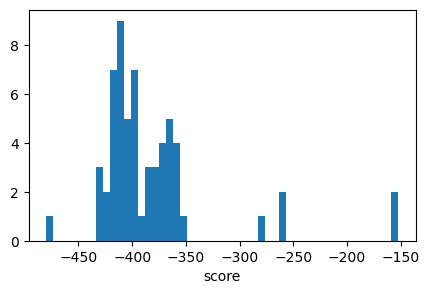

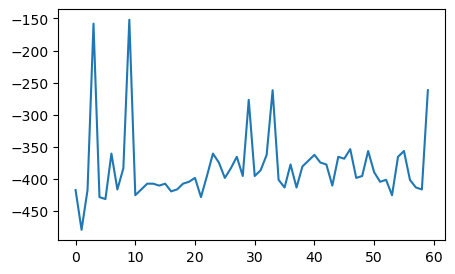

In [12]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

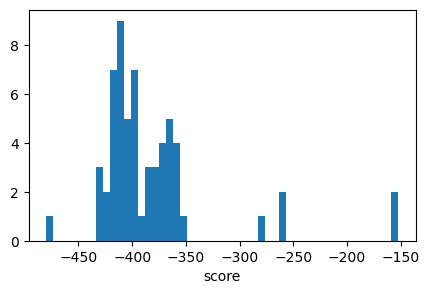

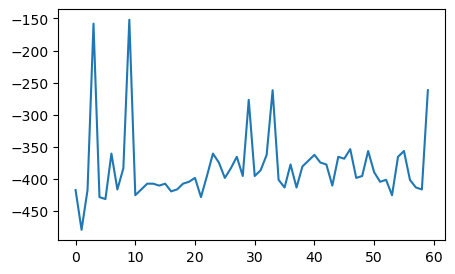

In [13]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:
# print(test.prog)
# print(test.actions)
# print(test.states)
# print(test.rewards)
# print(test.on_break)


In [ ]:
#  simple episode
# prog = []
# actions = []
# states = []
# rewards = []
# on_break = []
# on_break2 = []
# time_horizon = 480

# # get initial state/ set reward to 0
# s0 = mdp.get_state_ix()
# # s0 = mdp.get_state()
# r = 0
# agent = Agent()
# for i in range(time_horizon):
# #     a = fake_agent(s0, r)
# #     a = agent(s0, r)
    
#     a = agent.choose_action(s0)
#     s1, r = mdp(a)
#     s1 = mdp.get_state_ix()
#     agent.update(s0, s1, r)

#     # Q update
# #     break
    
#     s0 = s1

    
#     p_ = [self.states[k].progress for k in range(4)]
    
#     prog.append(p_)
#     actions.append(a)
#     states.append(self.current_state_ix)
#     rewards.append(r)
#     on_break.append(self.on_break)
#     on_break2.append(self.task_timer.on_break)
    
    
#     active_states = get_active_states(self.states,True)
#     if len(active_states) == 1:
#         break


# print(f'a:\t{a}')
# print(print_progress(self.states))

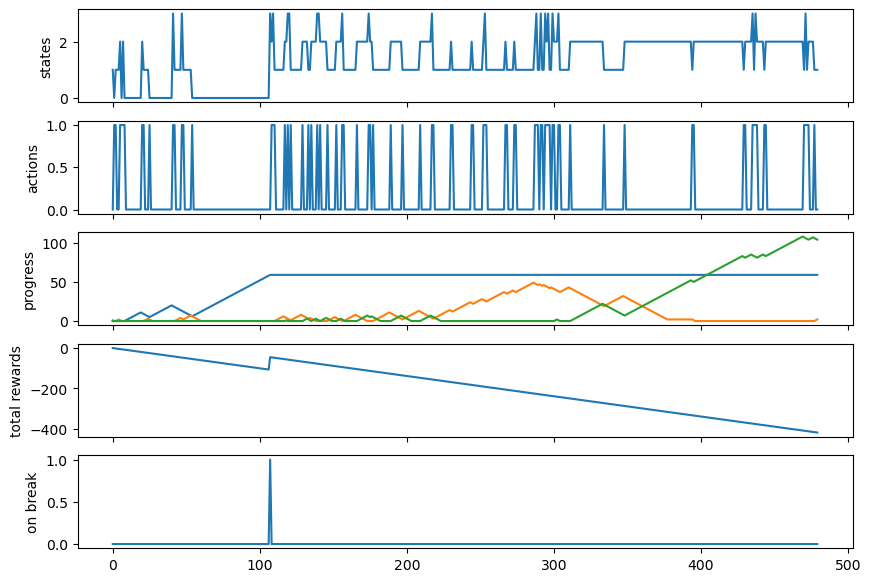

In [15]:

f, axs = plt.subplots(5,1, figsize=(10,7), sharex=True)

# index the episode you want to visualize
ep = 0

axs[0].plot(episode.states[ep])
axs[0].set_ylabel('states')
axs[1].plot(episode.actions[ep])
axs[1].set_ylabel('actions')
axs[2].plot(np.array(episode.prog[ep])[:,:-1])
axs[2].set_ylabel('progress')
axs[3].plot(np.cumsum(episode.rewards[ep]))
axs[3].set_ylabel('total rewards')
axs[4].plot(episode.on_break[ep])
axs[4].set_ylabel('on break')

# axs[3].set_yscale('log')

plt.show()

In [ ]:
agent.Qp